In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## ADMISSIONS + DIAGNOSIS

In [2]:
diag = pd.read_csv("ad_diag.csv") # read in csv file
# create 3 new columns breaking out ICD9 code
diag['FIRST_ICD9_DIAGNOSIS'] = np.where(diag['SEQ_NUM'] == 1, diag['ICD9_CODE'], 0)
diag['SECOND_ICD9_DIAGNOSIS'] = np.where(diag['SEQ_NUM'] == 2, diag['ICD9_CODE'], 0)
diag['THIRD_ICD9_DIAGNOSIS'] = np.where(diag['SEQ_NUM'] == 3, diag['ICD9_CODE'], 0)
# only take necessary columns
diag_condense = diag[['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'FIRST_ICD9_DIAGNOSIS', 'SECOND_ICD9_DIAGNOSIS', 'THIRD_ICD9_DIAGNOSIS']].copy()
# only choose rows corresponding to first, second, and third assigned ICD9 code
diag_c = diag_condense[(diag_condense['SEQ_NUM'] < 4)]

In [69]:
diag_c.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,FIRST_ICD9_DIAGNOSIS,SECOND_ICD9_DIAGNOSIS,THIRD_ICD9_DIAGNOSIS
0,22,165315,1.0,9678,0,0
1,22,165315,2.0,0,9693,0
2,22,165315,3.0,0,0,E9502
7,23,124321,1.0,2252,0,0
8,23,124321,2.0,0,3485,0


## Looking at ICD Frequency Within the Data

In [86]:
def icd_freq(dataset, cn):
    count_dict = {}
    for index, row in dataset.iterrows():
        #if row[cn] != '0' or 0:
        if row[cn] not in count_dict: 
            count_dict[row[cn]] = 0
        count_dict[row[cn]] = count_dict[row[cn]] + 1
    return((count_dict, len(dataset)))

In [87]:
def top_percent(freq_tup, perc):
    threshold = freq_tup[1] * perc
    # change it to a dataframe
    ww = pd.Series(freq_tup[0]).to_frame()
    ww.head()
    ww['ICD9'] = ww.index
    ww.columns = ['COUNT', 'ICD9']
    # sort it (greatest to least)
    ww.sort_values(by='COUNT', ascending=False)
    # work through until sum is > or == threshold
    sum_count = 0
    icds_in_count = []
    for index, row in ww.iterrows(): 
        if sum_count < threshold: 
            sum_count = sum_count + row[0]
            icds_in_count.append(row[1])
    return(icds_in_count)

In [88]:
full = icd_freq(diag, 3)
all_icd = top_percent(full, 0.1)
all_icd

['9678',
 '9693',
 'E9502',
 'E9503',
 '3488',
 '29620',
 '4019',
 '2252',
 '3485',
 '78039',
 '4241',
 '2720',
 '2724',
 'V4581',
 'V4579',
 'V1582',
 '41041',
 '41401',
 '53081']

In [95]:
first = icd_freq(icd_one, 0)

In [96]:
firsta_icd = top_percent(first, 0.1)
firsta_icd

['9678',
 '2252',
 '41041',
 '41071',
 '99604',
 '99674',
 '3453',
 '0389',
 '42789',
 '41401']

In [97]:
second = icd_freq(icd_two, 0)
seconda_icd = top_percent(second, 0.1)
seconda_icd

['9693',
 '3485',
 '41401',
 '25011',
 '4271',
 '4160',
 '20190',
 '4928',
 '4280',
 '42822',
 '4111',
 '99811',
 '0389',
 '5722',
 '03810',
 '78559',
 '3453',
 'E9102',
 '5849']

In [98]:
third = icd_freq(icd_three, 0)
thirda_icd = top_percent(third, 0.1)

In [99]:
thirda_icd

['E9502',
 '78039',
 '53081',
 '41401',
 '4280',
 '4111',
 '515',
 '49390',
 '4254',
 '4263',
 '496',
 '41511',
 '99592',
 '2867',
 '5849']

## ADMISSIONS + PATIENTS

In [4]:
pat = pd.read_csv('AD_PAT.csv')
# change ADMITTIME and DISCHTIME to datetime objects to make
# a new column for length of stay
pat['ADMITTIME'] = pd.to_datetime(pat['ADMITTIME'])
pat['DISCHTIME'] = pd.to_datetime(pat['DISCHTIME'])
pat['LENGTHOFSTAY'] = pat['DISCHTIME'] - pat['ADMITTIME']
pat['LENGTHOFSTAY_DAYS'] = [d.days for d in pat['LENGTHOFSTAY']]

## ADMISSIONS + ICU

In [5]:
icu = pd.read_csv('AD_ICU_PLACE.csv')
icu = icu[['SUBJECT_ID', 'HADM_ID', 'ICUFIRSTCAREUNIT', 'ICULASTCAREUNIT', 'ICUFIRSTWARDID', 'ICULASTWARDID','ICU_LOS']]
icu['SAMECARE'] = np.where(icu.ICUFIRSTCAREUNIT == icu.ICULASTCAREUNIT, 1, 0)
icu['SAMEWARD'] = np.where(icu.ICUFIRSTWARDID == icu.ICULASTWARDID, 1, 0)

## ADMISSIONS + CHART EVENTS (MIN/FIRST)

In [6]:
ce_min = pd.read_csv('AD_CE_MIN.csv')
ce_min = ce_min[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUE', 'VALUENUM']]
ce_min.columns = ['SUBJECT_ID', 'HADM_ID', 'FIRST_ITEMID', 'FIRST_VALUE', 'FIRST_VALUENUM']

categories = []
for index, row in ce_min.iterrows():
    try:
        int(row[3])
        categories.append(0)
    except:
        categories.append(row[3])

categories_final = []
for each in categories:
    try:
        float(each)
        categories_final.append(0)
    except:
        categories_final.append(each)
ce_min['FIRST_CATEGORY'] = categories_final

ce_min['FIRST_NUMBER'] = np.where(ce_min['FIRST_CATEGORY'] == 0, ce_min['FIRST_VALUE'], 0)
ce_min = ce_min[['SUBJECT_ID', 'HADM_ID', 'FIRST_ITEMID', 'FIRST_CATEGORY', 'FIRST_NUMBER']].copy()
grouped = ce_min[['FIRST_ITEMID', 'FIRST_CATEGORY']].copy()
grouped = grouped.drop_duplicates().sort_values(by=['FIRST_ITEMID'])

n = 0
m = 1
store = []
labels = []
for index, row in grouped.iterrows():
    if n == 0:
        store.append(row[0])
        labels.append(m)
    else:
        if row[0] != store[n-1]:
            m = 1
            labels.append(m)
            store.append(row[0])
        else:
            labels.append(m)
            store.append(row[0])
    n = n + 1
    m = m + 1

grouped['CATS'] = labels

together = ce_min.merge(grouped, left_on = ['FIRST_ITEMID', 'FIRST_CATEGORY'], right_on = ['FIRST_ITEMID', 'FIRST_CATEGORY'])
together = together[['SUBJECT_ID', 'HADM_ID', 'FIRST_ITEMID', 'CATS', 'FIRST_NUMBER']]
together['FIRST_ITEMID2'] = np.where(together.FIRST_ITEMID == 'None', -1, together.FIRST_ITEMID)


## ADMISSIONS + CHART EVENTS (MAX/LAST)

In [7]:
ce_max = pd.read_csv('AD_CE_MAX.csv')
ce_max = ce_max[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUE', 'VALUENUM']]
ce_max.columns = ['SUBJECT_ID', 'HADM_ID', 'LAST_ITEMID', 'LAST_VALUE', 'LAST_VALUENUM']

categories = []
for index, row in ce_max.iterrows():
    try:
        int(row[3])
        categories.append(0)
    except:
        categories.append(row[3])

categories_final = []
for each in categories:
    try:
        float(each)
        categories_final.append(0)
    except:
        categories_final.append(each)
ce_max['LAST_CATEGORY'] = categories_final

ce_max['LAST_NUMBER'] = np.where(ce_max['LAST_CATEGORY'] == 0, ce_max['LAST_VALUE'], 0)
ce_max = ce_max[['SUBJECT_ID', 'HADM_ID', 'LAST_ITEMID', 'LAST_CATEGORY', 'LAST_NUMBER']].copy()
grouped = ce_max[['LAST_ITEMID', 'LAST_CATEGORY']].copy()
grouped = grouped.drop_duplicates().sort_values(by=['LAST_ITEMID'])

n = 0
m = 1
store = []
labels = []
for index, row in grouped.iterrows():
    if n == 0:
        store.append(row[0])
        labels.append(m)
    else:
        if row[0] != store[n-1]:
            m = 1
            labels.append(m)
            store.append(row[0])
        else:
            labels.append(m)
            store.append(row[0])
    n = n + 1
    m = m + 1

grouped['LAST_CATS'] = labels

together_max = ce_max.merge(grouped, left_on = ['LAST_ITEMID', 'LAST_CATEGORY'], right_on = ['LAST_ITEMID', 'LAST_CATEGORY'])
together_max = together_max[['SUBJECT_ID', 'HADM_ID', 'LAST_ITEMID', 'LAST_CATS', 'LAST_NUMBER']]
together_max['LAST_ITEMID2'] = np.where(together_max.LAST_ITEMID == 'None', -1, together_max.LAST_ITEMID)


In [7]:
## BUT FIRST, CHECK LENGTHS OF DATA
print(len(diag_c))
print(len(pat))
print(len(icu))
print(len(together))
print(len(together_max))

129210
43407
96405
43407
43407


## MERGE INTO ONE DATASET TO USE FOR PREDICTIONS

In [8]:
diag_pat = diag_c.merge(pat, on=['SUBJECT_ID', 'HADM_ID'])
dp_icu = diag_pat.merge(icu, on=['SUBJECT_ID', 'HADM_ID'])
dpi_ce_min = dp_icu.merge(together, on=['SUBJECT_ID', 'HADM_ID'])
dpicm_cm = dpi_ce_min.merge(together_max, on=['SUBJECT_ID', 'HADM_ID'])

In [9]:
print(len(dpicm_cm))
print(dpicm_cm['ADMISSIONTYPE'].unique())
dpicm_cm.columns

287932
['EMERGENCY' 'URGENT']


Index(['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'FIRST_ICD9_DIAGNOSIS',
       'SECOND_ICD9_DIAGNOSIS', 'THIRD_ICD9_DIAGNOSIS', 'ADMITTIME',
       'DISCHTIME', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'ADMISSIONTYPE', 'DIAGNOSIS', 'GENDER', 'LENGTHOFSTAY',
       'LENGTHOFSTAY_DAYS', 'ICUFIRSTCAREUNIT', 'ICULASTCAREUNIT',
       'ICUFIRSTWARDID', 'ICULASTWARDID', 'ICU_LOS', 'SAMECARE', 'SAMEWARD',
       'FIRST_ITEMID', 'CATS', 'FIRST_NUMBER', 'FIRST_ITEMID2', 'LAST_ITEMID',
       'LAST_CATS', 'LAST_NUMBER', 'LAST_ITEMID2'],
      dtype='object')

In [10]:
#dpicm_cm['DIAGNOSIS_CODE'] = np.where(dpicm_cm['FIRST_ICD9_DIAGNOSIS'].not_null(), dpicm_cm['FIRST_ICD9_DIAGNOSIS'], 0)
#dpicm_cm['DIAGNOSIS_CODE'] = np.where(dpicm_cm['SECOND_ICD9_DIAGNOSIS'].not_null(), dpicm_cm['SECOND_ICD9_DIAGNOSIS'], dpicm_cm['DIAGNOSIS_CODE'])
#dpicm_cm['DIAGNOSIS_CODE'] = np.where(dpicm_cm['THIRD_ICD9_DIAGNOSIS'].not_null(), dpicm_cm['THIRD_ICD9_DIAGNOSIS'], dpicm_cm['DIAGNOSIS_CODE'])
dpicm_cm.to_csv('dpicm_cm.csv', index=False)

## CHANGE CATEGORICAL VARIABLES TO NUMERICAL

In [10]:
def choose_ICD9_set(data_bit, num_choice):
    returned_set_p1 = data_bit[(data_bit['SEQ_NUM'] == num_choice)]
    full_set = ['FIRST_ITEMID2', 'CATS', 'FIRST_NUMBER']
    full_set.extend(('LAST_ITEMID2', 'LAST_CATS', 'LAST_NUMBER'))
    full_set.extend(('ICUFIRSTCAREUNIT', 'ICULASTCAREUNIT', 'ICUFIRSTWARDID'))
    full_set.extend(('ICULASTWARDID', 'ICU_LOS', 'SAMECARE', 'SAMEWARD'))
    full_set.extend(('LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY'))
    full_set.extend(('DIAGNOSIS', 'GENDER', 'LENGTHOFSTAY_DAYS'))
    if num_choice == 1:
        use_set = ['FIRST_ICD9_DIAGNOSIS']
        for each in full_set:
            use_set.append(each)
        returned_set = returned_set_p1[use_set]
    if num_choice == 2:
        use_set = ['SECOND_ICD9_DIAGNOSIS']
        for each in full_set:
            use_set.append(each)
        returned_set = returned_set_p1[use_set]
    if num_choice == 3:
        use_set = ['THIRD_ICD9_DIAGNOSIS']
        for each in full_set:
            use_set.append(each)
        returned_set = returned_set_p1[use_set]

    return(returned_set)

In [11]:
icd9_one = choose_ICD9_set(dpicm_cm, 1)
icd9_two = choose_ICD9_set(dpicm_cm, 2)
icd9_three = choose_ICD9_set(dpicm_cm, 3)
#icd9_full = dpicm_cm[['DIAGNOSIS_CODE', 'FIRST_ITEMID2', 'CATS', 'FIRST_NUMBER', 'LAST_ITEMID2', 'LAST_CATS', 'LAST_NUMBER', 'ICUFIRSTCAREUNIT', 'ICULASTCAREUNIT', 'ICUFIRSTWARDID', 'ICULASTWARDID', 'ICU_LOS', 'SAMECARE', 'SAMEWARD', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'GENDER', 'LENGTHOFSTAY_DAYS']].copy()

In [12]:
language_replace = {'LANGUAGE':{}, 'RELIGION':{}, 'MARITAL_STATUS':{},
'ETHNICITY':{}, 'GENDER':{}, 'DIAGNOSIS':{}}

icu_care = icu[['ICUFIRSTCAREUNIT', 'ICULASTCAREUNIT']].copy()
icu_care = icu_care.drop_duplicates()

icu_ward = icu[['ICUFIRSTWARDID', 'ICULASTWARDID']].copy()
icu_ward = icu_ward.drop_duplicates()

In [13]:
def cats_across_columns(two_columns):
    to_replace = {}
    n = 1
    for index, row in two_columns.iterrows():
        if row[0] not in to_replace:
            to_replace[row[0]] = n
            n = n + 1
        if row[1] not in to_replace:
            to_replace[row[1]] = n
            n = n + 1
    return(to_replace)

In [14]:
care_replace = cats_across_columns(icu_care)
icu_care_replace = {'ICUFIRSTCAREUNIT':care_replace, 'ICULASTCAREUNIT':care_replace}

ward_replace = cats_across_columns(icu_ward)
icu_ward_replace = {'ICUFIRSTWARDID':ward_replace, 'ICULASTWARDID':ward_replace}

In [15]:
def assigning_labels(data_subset, replace_dict):
    for each_label in replace_dict:
        n = 1
        for each in data_subset[each_label].unique():
            replace_dict[each_label][each] = n
            n = n + 1

    return(replace_dict)

In [16]:
replace_one = assigning_labels(dpicm_cm, language_replace)
replace_full = {**replace_one, **icu_care_replace, **icu_ward_replace}

In [17]:
replace_full.keys()

dict_keys(['LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'DIAGNOSIS', 'ICUFIRSTCAREUNIT', 'ICULASTCAREUNIT', 'ICUFIRSTWARDID', 'ICULASTWARDID'])

In [18]:
def recode_cats(o_data, replace_dict): 
    for each_key in replace_dict: 
        o_data[each_key] = o_data[each_key].map(replace_dict[each_key])
    return(o_data)

In [19]:
# then apply recode
icd9_one = recode_cats(icd9_one, replace_full)
# replace nan with 0
icd_one = icd9_one.fillna(0)

# then apply recode
icd9_two = recode_cats(icd9_two, replace_full)
# replace nan with 0
icd_two = icd9_two.fillna(0)

# then apply recode
icd9_three = recode_cats(icd9_three, replace_full)
# replace nan with 0
icd_three = icd9_three.fillna(0)

In [20]:
print(len(icd_one))
len(icd_one[(icd_one['FIRST_ICD9_DIAGNOSIS'].notnull())])

96354


96354

In [21]:
print(len(icd_two))
len(icd_two[(icd_two['SECOND_ICD9_DIAGNOSIS'].notnull())])
#icd_two = icd_two.dropna()

96065


96065

In [22]:
print(len(icd_three))
len(icd_three[(icd_three['THIRD_ICD9_DIAGNOSIS'].notnull())])
#icd_three = icd_three.dropna()

95513


95513

## PREDICTING

In [23]:
def visualize_accuracy(acc_dict, file_name):
    objects = []
    performance = []
    for each in acc_dict:
        objects.append(each)
        performance.append(acc_dict[each])

    y_pos = np.arange(len(objects))

    plt.bar(y_pos, performance, align='center', alpha=0.5, color=(254/255, 168/255, 182/255))
    plt.xticks(y_pos, objects)
    plt.ylim(0, 1) 
    plt.ylabel('Accuracy')
    plt.xlabel('Test Size')
    plt.title('Accuracy Across Test/Train Sizes')
    plt.savefig(file_name)
    plt.close()

In [50]:
def visualize_accuracy_all(dict1, dict2, dict3, file_name):
    objects1 = []
    performance1 = []
    for each in dict1:
        objects1.append(each)
        performance1.append(dict1[each])
        
    objects2 = []
    performance2 = []
    for each in dict2:
        objects2.append(each)
        performance2.append(dict2[each])
        
    objects3 = []
    performance3 = []
    for each in dict3:
        objects3.append(each)
        performance3.append(dict3[each])
    
    
    
    N = len(objects1)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.25       # the width of the bars

    fig = plt.figure()
    ax = fig.add_subplot(111)
    rects1 = ax.bar(ind, performance1, width, color=(254/255, 168/255, 182/255))
    rects2 = ax.bar(ind+width, performance2, width, color='gray')
    rects3 = ax.bar(ind+(2*width), performance3, width, color=(254/255, 135/255, 155/255))
    
    
    # add some
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy Across Test/Train Sizes')
    ax.set_xticks(ind + width)
    ax.set_xticklabels( ('0.1', '0.2', '0.3', '0.4', '0.5') )
    
    ax.set_ylim(0, 1)
    ax.legend( (rects1[0], rects2[0], rects3[0]), ('First', 'Second', 'Third') )
    
    #plot = dtf.plot()
    #fig = plot.get_figure()
    fig.savefig(file_name)
    
    #ax.savefig(file_name)
    #ax.close()

In [24]:
def forest_sizechange(o_data, test_list, icd9):

    if icd9 == 1: 
        icd_col = 'FIRST_ICD9_DIAGNOSIS'
    elif icd9 == 2: 
        icd_col = 'SECOND_ICD9_DIAGNOSIS'
    elif icd9 == 3:  
        icd_col = 'THIRD_ICD9_DIAGNOSIS'
    else: 
        icd_col = 'ICD9_DIAGNOSIS'
        
    acc_each = {}
    for each_test in test_list: 
        otrain,otest = train_test_split(o_data, test_size=each_test)
        rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
        rf_model.fit(otrain.ix[:,1:],otrain[icd_col])
        predicted_labels = rf_model.predict(otest.ix[:,1:])
        new_col = 'predicted_rf_tree_' + str(each_test)
        otest[new_col] = predicted_labels
        accuracy = accuracy_score(otest[icd_col], predicted_labels)
        acc_each[each_test] = accuracy
        
    return(acc_each)

In [25]:
# Filter all warnings.
import warnings
warnings.filterwarnings('ignore')

In [26]:
t = [0.1, 0.2, 0.3, 0.4, 0.5]

In [27]:
first_icd9 = forest_sizechange(icd_one, t, 1)
#visualize_accuracy(first_icd9, 'first_icd9.png')

In [28]:
second_icd9 = forest_sizechange(icd_two, t, 2)
#visualize_accuracy(second_icd9, 'second_icd9.png')

In [29]:
third_icd9 = forest_sizechange(icd_three, t, 3)
#visualize_accuracy(third_icd9, 'third_icd9.png')

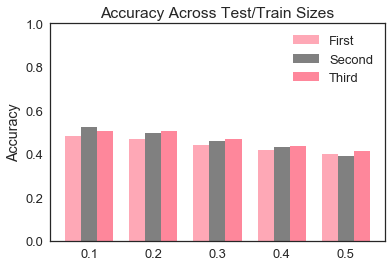

In [51]:
visualize_accuracy_all(first_icd9, second_icd9, third_icd9, "together_accuracy.png")

In [24]:
icd_one_re = icd_one.rename({'FIRST_ICD9_DIAGNOSIS':'ICD9_DIAGNOSIS'}, axis=1)
icd_two_re = icd_two.rename({'SECOND_ICD9_DIAGNOSIS':'ICD9_DIAGNOSIS'}, axis=1)
icd_three_re = icd_three.rename({'THIRD_ICD9_DIAGNOSIS':'ICD9_DIAGNOSIS'}, axis=1)
icd_full = pd.concat([icd_one_re, icd_two_re, icd_three_re])

In [26]:
full_icd9 = forest_sizechange(icd_full, t, 4)
visualize_accuracy(full_icd9, 'full_icd9.png')

In [25]:
icd_one.to_csv("icd_one.csv", index=False)
icd_two.to_csv("icd_two.csv", index=False)
icd_three.to_csv("icd_three.csv", index=False)
icd_full.to_csv("icd_full.csv", index=False)

## RANDOM SAMPLING

## PREDICTING EACH ICD-9 CODE

In [29]:
def forest_set(o_data, ts, icd9):

    if icd9 == 1: 
        icd_col = 'FIRST_ICD9_DIAGNOSIS'
    elif icd9 == 2: 
        icd_col = 'SECOND_ICD9_DIAGNOSIS'
    elif icd9 == 3:  
        icd_col = 'THIRD_ICD9_DIAGNOSIS'
    else: 
        icd_col = 'ICD9_DIAGNOSIS'
        
    otrain,otest = train_test_split(o_data, test_size=ts)
    rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
    rf_model.fit(otrain.ix[:,1:],otrain[icd_col])
    predicted_labels = rf_model.predict(otest.ix[:,1:])
    
    otest['predicted_rf_tree'] = predicted_labels
    accuracy = accuracy_score(otest[icd_col], predicted_labels)
    
    acc_by_code = {}
    for each_icd in otest[icd_col].unique():
        otest_bit = otest[(otest[icd_col] == each_icd)]
        accuracy_set = accuracy_score(otest_bit[icd_col], otest_bit['predicted_rf_tree'])
        acc_by_code[each_icd] = accuracy_set
        
    return((accuracy, acc_by_code))

In [47]:
def viz_acc_icd(acc_tup, file_name):
    objects = []
    performance = []
    for each_key in acc_tup[1]:
        if acc_tup[1][each_key] > 0:
            objects.append(each_key)
            performance.append(acc_tup[1][each_key])
    threshold = acc_tup[0]
    y_pos = np.arange(len(objects))

    plt.bar(y_pos, performance, align='center', alpha=0.5, color=(254/255, 168/255, 182/255))
    #plt.xticks(y_pos, objects, rotation=90)
    #[0., len(objects)], 
    plt.axhline(threshold, color="gray")
    plt.ylim(0, 1) 
    plt.ylabel('Accuracy')
    plt.xlabel('ICD-9 Code')
    plt.title('Accuracy Across ICD-9 Codes')
    plt.savefig(file_name)
    plt.close()
    #plt.show()

In [54]:
def which_codes(code_dict):
    over_ninety = {}
    for each_code in code_dict: 
        if code_dict[each_code] > .90: 
            over_ninety[each_code] = code_dict[each_code]
    onine = pd.Series(over_ninety).to_frame()
    onine.columns = ['Accuracy']
    return(onine)

In [62]:
icd_one_sam = icd_one.sample(frac=0.1)

In [42]:
return_acc_one = forest_set(icd_one_sam, 0.3, 1)

In [48]:
viz_acc_icd(return_acc_one, 'acc_one_test.png')

In [55]:
ret = which_codes(return_acc_one[1])
ret.head()

,Accuracy
7100,1.0
28959,1.0
3239,1.0
9752,1.0
76513,1.0


## PREDICTING PART OF ICD9 CODE

In [63]:
icd_one_sam['FIRSTDIGITS'] = icd_one_sam['FIRST_ICD9_DIAGNOSIS'].str[:3]
#icd_one_sam['LASTDIGITS'] = icd_one_sam['FIRST_ICD9_DIAGNOSIS'].str[-3:]
icd_one_sam.head()

,FIRST_ICD9_DIAGNOSIS,FIRST_ITEMID2,CATS,FIRST_NUMBER,LAST_ITEMID2,LAST_CATS,LAST_NUMBER,ICUFIRSTCAREUNIT,ICULASTCAREUNIT,ICUFIRSTWARDID,...,SAMECARE,SAMEWARD,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,GENDER,LENGTHOFSTAY_DAYS,FIRSTDIGITS
68943,41031,51,1,136,51,1,44,4,4,3,...,1,1,1,9,1,2,47,1,1,410
8485,4373,27,4,0,47,1,0,3,3,7,...,1,1,1,1,2,6,484,2,1,437
160554,3320,27,4,0,27,9,0,1,1,8,...,1,1,2,5,1,1,6921,2,28,332
227162,4251,226381,4,0,226228,2,0,4,4,4,...,1,1,2,2,1,9,9529,1,7,425
58429,86504,69,1,0,31,7,0,5,3,7,...,0,0,1,1,3,1,3053,1,21,865


In [115]:
def forest_model(o_data, ts, icd9):

    if icd9 == 1: 
        icd_col = 'FIRST_ICD9_DIAGNOSIS'
    elif icd9 == 2: 
        icd_col = 'SECOND_ICD9_DIAGNOSIS'
    elif icd9 == 3:  
        icd_col = 'THIRD_ICD9_DIAGNOSIS'
    elif icd9 == 4: 
        icd_col = 'FIRSTDIGITS'
    else: 
        icd_col = 'ICD9_DIAGNOSIS'
         
    otrain,otest = train_test_split(o_data, test_size=ts)
    rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
    rf_model.fit(otrain.ix[:,1:],otrain[icd_col])
    predicted_labels = rf_model.predict(otest.ix[:,1:])
    
    otest['rf_predicted'] = predicted_labels
    accuracy = accuracy_score(otest[icd_col], predicted_labels)
    
    return((accuracy, rf_model))

In [112]:
icd_one_sam = icd_one.sample(frac=0.1)
icd_one_sam['FIRSTDIGITS'] = icd_one_sam['FIRST_ICD9_DIAGNOSIS'].str[:3]
testing = forest_model(icd_one_sam, 0.3, 4)

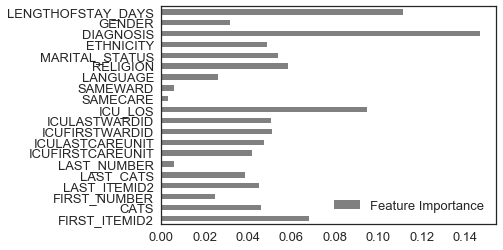

In [113]:
fi = testing[1].feature_importances_

#feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance':fi},
            index=diag_pat_one_train.columns[1:]).plot(kind='barh', color="gray")

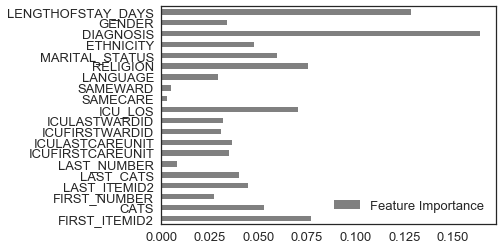

In [116]:
one = forest_model(icd_one, 0.3, 1)
fi = one[1].feature_importances_
pd.DataFrame({'Feature Importance':fi},
            index=diag_pat_one_train.columns[1:]).plot(kind='barh', color="gray")

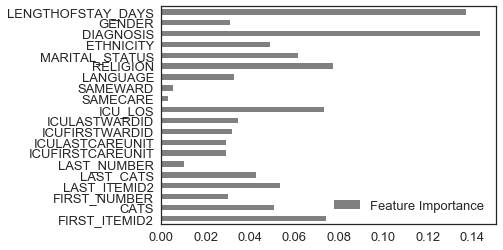

In [117]:
two = forest_model(icd_two, 0.3, 2)
fi = two[1].feature_importances_
pd.DataFrame({'Feature Importance':fi},
            index=diag_pat_one_train.columns[1:]).plot(kind='barh', color="gray")

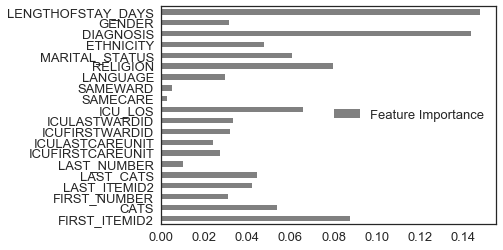

In [118]:
three = forest_model(icd_three, 0.3, 3)
fi = three[1].feature_importances_
pd.DataFrame({'Feature Importance':fi},
            index=diag_pat_one_train.columns[1:]).plot(kind='barh', color="gray")

In [47]:
diag_pat_one_train,diag_pat_one_test = train_test_split(icd9_one, test_size=0.3)

In [48]:
rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model.fit(diag_pat_one_train.ix[:,1:],diag_pat_one_train.FIRST_ICD9_DIAGNOSIS)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [49]:
predicted_labels = rf_model.predict(diag_pat_one_test.ix[:,1:])
diag_pat_one_test['predicted_rf_tree'] = predicted_labels

## ACCURACY

In [50]:
accuracy = accuracy_score(diag_pat_one_test.FIRST_ICD9_DIAGNOSIS, predicted_labels)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 43.43%


## FEATURE IMPORTANCE

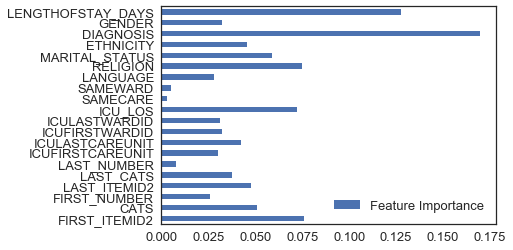

In [51]:
feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=diag_pat_one_train.columns[1:]).plot(kind='barh', color="gray")

## TUNING THE MODEL

In [105]:
# icd_one
# icd_two
# icd_three
# icd_full
icd_one_sam = icd_one.sample(frac=0.1)

In [106]:
param_grid = {
                 'n_estimators': [5, 10, 15, 20], # number of trees in the forest
                 'max_depth': [2, 5, 7, 9], # maximum depth of the tree
             }

In [107]:
rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
diag_pat_one_train,diag_pat_one_test = train_test_split(icd_one_sam, test_size=0.3)

In [108]:
grid_clf = GridSearchCV(rf_model, param_grid, cv=10)
grid_clf.fit(diag_pat_one_train.ix[:,1:],diag_pat_one_train.FIRST_ICD9_DIAGNOSIS)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20], 'max_depth': [2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [109]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [110]:
print(grid_clf.best_params_)
# accuracy of best model = 
grid_clf.best_score_

{'max_depth': 9, 'n_estimators': 20}


0.15999406880189798